In [37]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import operator

In [67]:
filePath = "data/ml-100k/u1.base"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]

# indexing on users/movies starts at 1, reset to index from 0, this will be important when we do testing
datapoints = np.array([[row[0], row[1], row[2], row[3]] for row in datapoints])
np.random.shuffle(datapoints)

# Used in precision eval... not rly needed given datapoints
user_items = defaultdict(list)
for row in datapoints:
    user_items[row[0]].append(row[1])

user_ids = set([datapoint[0] for datapoint in datapoints])
n_users = len(user_ids)
max_user = max(user_ids) + 1
print("n users:", n_users)
items_ids = set([datapoint[1] for datapoint in datapoints])
n_items = len(items_ids)
max_item = max(items_ids) + 1
print("n items:", n_items)

n users: 943
n items: 1650


In [196]:
import random

# sanity check vs datapoints
user_item_cnts = {}
for user, movies in user_items.items():
    user_item_cnts[user] = len(movies)

top_users = dict(sorted(user_item_cnts.items(), key=operator.itemgetter(1), reverse=True)[:227])
print("User_ids with most watched movies: ", list(top_users.keys())[0:20], ". . .")

cold_start_users = random.sample(list(top_users.keys()), k=200) # Select k users randomly
print("\nNum cold start users: ", len(cold_start_users))

drift_users = random.sample(list(top_users.keys()), k=200)
print("\nDrift user ids: ", drift_users)

User_ids with most watched movies:  [655, 405, 450, 537, 416, 846, 682, 13, 880, 429, 896, 592, 796, 758, 561, 435, 551, 804, 474, 889] . . .

Num cold start users:  200

Drift user ids:  [693, 374, 716, 846, 484, 648, 659, 896, 458, 738, 416, 763, 774, 919, 90, 566, 671, 303, 339, 805, 880, 379, 487, 943, 887, 503, 721, 407, 661, 807, 450, 601, 417, 650, 493, 883, 624, 642, 894, 279, 453, 851, 343, 387, 654, 276, 181, 588, 634, 293, 833, 496, 269, 798, 699, 457, 393, 447, 222, 901, 445, 455, 790, 524, 194, 618, 608, 429, 548, 437, 468, 201, 436, 472, 698, 933, 899, 498, 151, 715, 207, 299, 577, 903, 95, 514, 454, 497, 347, 495, 664, 758, 773, 551, 479, 788, 916, 527, 474, 892, 456, 806, 405, 629, 593, 907, 878, 425, 345, 823, 913, 886, 394, 536, 18, 363, 882, 406, 442, 327, 709, 435, 328, 804, 109, 815, 314, 868, 712, 655, 643, 934, 757, 707, 286, 301, 521, 545, 342, 795, 639, 606, 627, 535, 682, 864, 130, 870, 848, 936, 796, 537, 389, 543, 504, 533, 7, 1, 506, 766, 927, 847, 94, 13, 

In [193]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def movie_genres(movie_ids):
    file = "data/ml-100k/u.item" 
    movies = pd.read_csv(file, sep='|', header=None, encoding='UTF-8')
    drop_cols = [2, 3, 4]
    movies = movies.drop(drop_cols, axis=1)
    col_names = ["movie_id", "title", "Unk", "Action", "Adventure", "Animation",
                  "Childrens", "Comedy", "Crime", "Documentary", "Drama",
                  "Fantasy", "Film_Noir", "Horror", "Musical", "Mystery",
                  "Romance", "Sci_Fi", "Thriller", "War", "Western"]
    movies.columns=col_names
    movies.head()
    return movies[movies['movie_id'].isin(movie_ids)].drop('title', axis=1)

def order_movies(userId, movie_split=60):
    file = "data/ml-100k/u1.base"
    with open(filePath, "rt") as dataPath:
        raw_data = dataPath.read().splitlines()
    datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]
    datapoints = np.array([[row[0], row[1], row[3]] for row in datapoints if row[0] == userId])
    sorted(datapoints, key = lambda x: int(x[2]))
    movie_set1, movie_set2 = [], []
    count = 0
    for row in datapoints:
        count += 1
        if count <= movie_split:
            movie_set1.append(row[1])
        elif movie_split < count <= movie_split*2:
            movie_set2.append(row[1])
        else:
            break
    if len(movie_set1) != len(movie_set2):
        print("Error: Movie set lengths differ!")
        return -1, -1
    return movie_set1, movie_set2

def genre_distribution(genre_matrix):
    col_sums = np.sum(genre_matrix.drop('movie_id', axis=1), axis=0)
    distribution = col_sums/sum(col_sums)
    return distribution

def getCosineSimilarity(userId, movie_split):
    # Get list of viewed movies ordered by timestamp
    movie_set1, movie_set2 = order_movies(userId, movie_split)
    # Get genre information for sets of movies
    genre_matrix1 = movie_genres(movie_set1)
    genre_matrix2 = movie_genres(movie_set2)
    # Get genre distribution vectors set1 vs set2
    dist1 = genre_distribution(genre_matrix1)
    dist2 = genre_distribution(genre_matrix2)
    # Calculate cosine similarity between vectors
    similarity = cosine_similarity(np.array(dist1).reshape(1,-1), np.array(dist2).reshape(1,-1))
    return similarity[0][0]
    

In [197]:
cosim_dict = {}
movie_split = 60
for user in drift_users:
    cosim_dict[user] = getCosineSimilarity(user, movie_split) # Slow since repeat file reads - fix if not lazy

In [210]:
lowest_cosim_ids = sorted(cosim_dict, key=cosim_dict.get)[0:5]
lowest_cosim_ids

[279, 496, 286, 698, 901]

In [235]:
def softmax(x):
    # subtract max value to prevent overflow\n"
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

# computes average and standard deviation MRR for samples
def mrr(R, U, V, samples):
    mrrs = []
    #print(R[samples, :][0])
    for s in samples:
        mrr = 0.0
        rating_count = np.sum(R[s, :] >= 3.0)
        if rating_count == 0:
            continue
        pred = np.matmul(U[s], V.T)
        predRank = np.argsort(np.argsort(-pred)) + 1
        rs, cs = R[s, :].nonzero()
        for j in cs:
            mrr += (1.0 / predRank[j])
        mrr /= rating_count
        mrrs.append(mrr)
    return np.mean(mrrs), np.std(mrrs)

def stratified_resample(weights):
    N = len(weights)
    # make N subdivisions, chose a random position within each one
    positions = (np.random.random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [214]:
""" ONLY RUN IF TESTING ON DRIFT USERS ONLY """
filePath = "data/ml-100k/u1.base"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]

# indexing on users/movies starts at 1, reset to index from 0, this will be important when we do testing
drift_users = set(lowest_cosim_ids)
datapoints = np.array([[row[0], row[1], row[2], row[3]] for row in datapoints if row[0] in drift_users])
# timestamp sorted. So algo will go throw movies as if seeing user actions sequentially
datapoints = sorted(datapoints, key = lambda x: int(x[3]))


In [275]:
n_particles = 2 
k = 5 
var = 0.5
particles = [(1 / n_particles, {"u": np.random.normal(size=(max_user, k)),
                                "v": np.random.normal(size=(max_item, k)),
                                "var_u": 1.0,
                                "var_i": 1.0}) for _ in range(n_particles)]

# get mean rating to make rating data centered at 0
#print(datapoints[:, 2])
#mean_rating = np.mean(datapoints[:, 2])
#data_store = {u_id: {row[1]: row[2] - mean_rating for row in datapoints if row[0] == u_id} for u_id in user_ids}


data_store = {u_id: {row[1]: row[2] for row in datapoints if row[0] == u_id} for u_id in drift_users}

user_history = {} # user_rating_history[user_id]["item_ids"], user_rating_history[user_id]["ratings"]
item_history = {} # item_rating_history[item_id]["user_ids"], item_rating_history[item_id]["ratings"]
ses = []
ctr = 0
ctr_hist = []
#U_trace_hist =  [] #[ np.linalg.norm(particles[0][1]['u'],'fro') ]
#V_trace_hist = [] # [ np.linalg.norm(particles[0][1]['v'],'fro') ]
# initialize drift test
drift1 = {}
drift2 = {}
rand1 = {}
rand2 = {}
user_cnt = {}
for u_id in data_store.keys():
    print(u_id)
    drift1[u_id] = []
    drift2[u_id] = []
    user_cnt[u_id] = 0
    rand1[u_id] = []
    rand2[u_id] = []

# what we're going to do here is assume that OUR system made the item recommendation and is observing the
# rating we have in the dataset ... it's sort of like we're starting at line 11
for _idx in range(len(datapoints)):

    # randomly get a user
    user_id = np.random.choice([i for i in data_store.keys()])
    user_items = [i for i in data_store[user_id].keys()]
    
    # highest rating this user has
    highest_rating = max(data_store[user_id].values())
    # get highest rated items
    highest_rated_items = [x for x in data_store[user_id].keys() if data_store[user_id][x] >= highest_rating]
    # get indices for items this user rated
    indices = np.array(user_items)
    
    # randomly select a particle
    random_particle = np.random.choice(range(n_particles))
    particle = particles[random_particle]
    
    # predict a rating only for the items rated by that user
    predicted_rating = np.dot(particle[1]["u"][user_id, :], particle[1]["v"][indices, :].T)

    # get the item id
    max_rating_ind = np.argmax(predicted_rating)
    item_id = [i for i in data_store[user_id].keys()][max_rating_ind]
    

    # add to ctr if possible
    if item_id in highest_rated_items:
        ctr += 1
    ctr_hist.append(ctr / (_idx + 1))
    
    # get the true rating
    rating = data_store[user_id][item_id]
    
    # For drift_users - track performance
    user_cnt[user_id] += 1
    if item_id in highest_rated_items and rating >= 3:
        if user_cnt[user_id] <= 60:
            drift1[user_id].append(1)
        elif 60 < user_cnt[user_id] <= 120:
            drift2[user_id].append(1)
    else:
        if user_cnt[user_id] <= 60:
            drift1[user_id].append(0)
        elif 60 < user_cnt[user_id] <= 120:
            drift2[user_id].append(0)
            
    # Random recommendation baseline
    rand_id = np.random.choice([i for i in data_store[user_id].keys()])
    if rand_id in highest_rated_items and rating > 3:
        if user_cnt[user_id] <= 60:
            rand1[user_id].append(1)
        elif 60 < user_cnt[user_id] <= 120:
            rand2[user_id].append(1)
    else:
        if user_cnt[user_id] <= 60:
            rand1[user_id].append(0)
        elif 60 < user_cnt[user_id] <= 120:
            rand2[user_id].append(0)
    
    # delete this item from this user
    del data_store[user_id][item_id]
    
    # delete the user from the data store if they have no reviews left
    if not data_store[user_id]:
        del data_store[user_id]
        
    error = predicted_rating[max_rating_ind] - rating
    se = error ** 2
    if _idx % 101 == 0:
        ses.append(se)
    if _idx % 1000== 0:
        print("squared error: {:.2f}".format(se))

    # line 17
    precision_u_i = []
    eta_u_i = []
    for particle in particles:
        if user_id not in user_history:
            precision_u_i.append(np.eye(k))
            eta_u_i.append(np.zeros(k))
        else:
            v_j = particle[1]["v"][user_history[user_id]["item_ids"], :]
            lambda_u_i = 1 / var * np.dot(v_j.T, v_j) + 1 / particle[1]["var_u"] * np.eye(k)

            precision_u_i.append(lambda_u_i)

            eta = np.sum(
                np.multiply(
                    v_j,
                    np.array(user_history[user_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
            eta_u_i.append(eta.reshape(-1))

    # line 18
    weights = []
    mus = [1 / var * np.dot(np.linalg.inv(lambda_), eta) for lambda_, eta in zip(precision_u_i, eta_u_i)]
    for particle, mu, precision in zip(particles, mus, precision_u_i):
        v_j = particle[1]["v"][item_id, :]
        cov = 1 / var + np.dot(np.dot(v_j.T, precision), v_j)
        w = np.random.normal(
            np.dot(v_j.T, mu),
            cov
        )
        weights.append(w)
    normalized_weights = softmax(weights)
    
    # Generate trace plots of U, V
#     U_trace, V_trace = 0, 0
#     for particle, weight in zip(particles, normalized_weights):
#         U_trace += particle[1]["u"] * weight
#         V_trace += particle[1]["v"] * weight
#     U_trace_hist.append(np.linalg.norm(U_trace, 'fro'))
#     V_trace_hist.append(np.linalg.norm(V_trace, 'fro'))

    # line 19
    ds = [np.random.choice(range(n_particles), p=normalized_weights) for _ in range(n_particles)]
    p_prime = []
    for d in ds:
        p_prime.append((1 / n_particles, particles[d][1]))

    for particle, precision, e in zip(p_prime, precision_u_i, eta_u_i):

        # line 21
        v_j = particle[1]["v"][item_id, :]
        add_to_precision = 1 / var * np.dot(v_j.reshape(-1, 1), v_j.reshape(1, -1))
        precision += add_to_precision

        add_to_eta = rating * v_j
        e += add_to_eta

        # line 22
        particle[1]["u"][user_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision), e),
            np.linalg.inv(precision)
        )
        
        
        # line 24
        if item_id not in item_history:
            precision_v_i = np.eye(k)
            eta = np.zeros(k)
        else:
            u_i = particle[1]["u"][item_history[item_id]["user_ids"], :]
            precision_v_i = 1 / var * \
                np.dot(u_i.T, u_i) + \
                1 / particle[1]["var_i"] * np.eye(k)

            eta = np.sum(
                np.multiply(
                    u_i,
                    np.array(item_history[item_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
        # line 25
        particle[1]["v"][item_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision_v_i), eta),
            np.linalg.inv(precision_v_i)
        )

    # line 28
    particles = p_prime

    if user_id not in user_history:
        user_history[user_id] = {"item_ids": [], "ratings": []}
    if item_id not in item_history:
        item_history[item_id] = {"user_ids": [], "ratings": []}
    user_history[user_id]["item_ids"].append(item_id)
    user_history[user_id]["ratings"].append(rating)
    item_history[item_id]["user_ids"].append(user_id)
    item_history[item_id]["ratings"].append(rating)

np.save("results/train_Particles={}_k={}_var={}.npy".format(n_particles, k, var), particles)
np.save("results/train_MSE_hist_p={}_k={}_var={}.npy".format(n_particles, k, var), ses)   
    

901
496
279
698
286
squared error: 0.34


In [276]:
for user in drift1.keys():
    rand_sum = sum(rand1[user]) + sum(rand2[user])
    drift_sum = sum(drift1[user]) + sum(drift2[user])
    #print("random sum: {} | drift sum: {}".format(rand_sum, drift_sum))
    print("user: ", user, "  drift1:", sum(drift1[user]), "  rand1:", sum(rand1[user]))
    print("user: ", user, "  drift2:", sum(drift2[user]), "  rand2:", sum(rand2[user]))
    print()


user:  901   drift1: 15   rand1: 21
user:  901   drift2: 24   rand2: 18

user:  496   drift1: 8   rand1: 7
user:  496   drift2: 14   rand2: 5

user:  279   drift1: 10   rand1: 1
user:  279   drift2: 4   rand2: 0

user:  698   drift1: 3   rand1: 0
user:  698   drift2: 5   rand2: 3

user:  286   drift1: 22   rand1: 11
user:  286   drift2: 15   rand2: 14



In [283]:
movies_rec = user_history[901]['item_ids']
movie_set1 = movies_rec[0:60]
movie_set2 = movies_rec[61:121]
print(len(movie_set1) == len(movie_set2))

genre_matrix1 = movie_genres(movie_set1)
genre_matrix2 = movie_genres(movie_set2)
dist1 = genre_distribution(genre_matrix1)
dist2 = genre_distribution(genre_matrix2)
similarity = cosine_similarity(np.array(dist1).reshape(1,-1), np.array(dist2).reshape(1,-1))[0][0]

print(dist1)
print()
print(dist2)
print()
print(dist1-dist2)
print(similarity)

True
Unk            0.000000
Action         0.128788
Adventure      0.106061
Animation      0.007576
Childrens      0.075758
Comedy         0.212121
Crime          0.000000
Documentary    0.000000
Drama          0.090909
Fantasy        0.007576
Film_Noir      0.007576
Horror         0.007576
Musical        0.030303
Mystery        0.007576
Romance        0.098485
Sci_Fi         0.098485
Thriller       0.060606
War            0.060606
Western        0.000000
dtype: float64

Unk            0.000000
Action         0.128571
Adventure      0.107143
Animation      0.007143
Childrens      0.092857
Comedy         0.192857
Crime          0.028571
Documentary    0.000000
Drama          0.114286
Fantasy        0.007143
Film_Noir      0.000000
Horror         0.021429
Musical        0.014286
Mystery        0.007143
Romance        0.085714
Sci_Fi         0.085714
Thriller       0.057143
War            0.035714
Western        0.014286
dtype: float64

Unk            0.000000
Action         0.000216
Adv

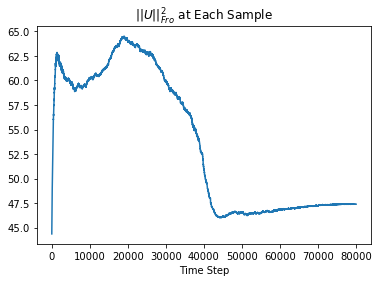

In [104]:
plt.plot(range(len(U_trace_hist)), U_trace_hist)
plt.title("$\|\|U\|\|_{Fro}^2$ at Each Sample")
plt.xlabel("Time Step")
plt.savefig("weird_U_norm_trace.png")
plt.show()


# plt.plot(range(len(V_trace_hist)), V_trace_hist)
# plt.title("$\|V\|_{Fro}^2$ at Each Sample")
# plt.xlabel("Time Step")
# plt.show()

In [57]:
import random

def test(particles, data):
    
    user_ids = set([item[0] for item in data])
    items_ids = set([item[1] for item in data])
    data_store = {u_id: {row[1]: row[2] for row in data if row[0] == u_id} for u_id in user_ids}
    user_history = {} # user_rating_history[user_id]["item_ids"], user_rating_history[user_id]["ratings"]
    item_history = {} # item_rating_history[item_id]["user_ids"], item_rating_history[item_id]["ratings"]

    #Evaluation stuffs
    precision = 0
    ses = []
    precision_list = []
    
    for _idx in range(len(data)):
        
        # randomly get a user
        user_id = np.random.choice([i for i in data_store.keys()])
        user_items = [i for i in data_store[user_id].keys()]
        
        # get indices for items this user rated
        indices = np.array(user_items)
        
        # randomly select a particle
        random_particle = np.random.choice(range(len(particles)))
        particle = particles[random_particle]
        
        # predict a rating only for the items rated by that user
        predicted_rating = np.dot( particle[1]["u"][user_id, :], particle[1]["v"][indices, :].T)
        
        # get the item id
        max_rating_ind = np.argmax(predicted_rating)
        item_id = [i for i in data_store[user_id].keys()][max_rating_ind]
        
        # get the true rating
        rating = data_store[user_id][item_id]

        # delete this item from this user
        del data_store[user_id][item_id]

        # delete the user from the data store if they have no reviews left
        if not data_store[user_id]:
            del data_store[user_id]
          

        #pred = predicted_rating[max_rating_ind]
        pred = random.randint(1,5)

        if pred > 5:
            pred = 5
        elif pred < 1:
            pred = 1
    
        error = pred - rating
        se = error ** 2
        
        # Precision
        if pred >= 4 and rating >= 4:
            precision += 1
        if _idx % 10 == 0:
            ses.append(se)
        if _idx % 100 == 0:
            print("squared error: {:.2f}".format(se))
        if _idx in [10, 20, 40 ,60, 80, 120]:
                precision_list.append((_idx, precision))
        
        # line 17
        precision_u_i = []
        eta_u_i = []
        for particle in particles:
            if user_id not in user_history:
                precision_u_i.append(np.eye(k))
                eta_u_i.append(np.zeros(k))
            else:
                v_j = particle[1]["v"][user_history[user_id]["item_ids"], :]
                lambda_u_i = 1 / var * np.dot(v_j.T, v_j) + 1 / particle[1]["var_u"] * np.eye(k)

                precision_u_i.append(lambda_u_i)

                eta = np.sum(
                    np.multiply(
                        v_j,
                        np.array(user_history[user_id]["ratings"]).reshape(-1, 1)
                    ),
                    axis=0
                )
                eta_u_i.append(eta.reshape(-1))

        # line 18
        weights = []
        mus = [1 / var * np.dot(np.linalg.inv(lambda_), eta) for lambda_, eta in zip(precision_u_i, eta_u_i)]
        for particle, mu, precision in zip(particles, mus, precision_u_i):
            v_j = particle[1]["v"][item_id, :]
            cov = 1 / var + np.dot(np.dot(v_j.T, precision), v_j)
            w = np.random.normal(
                np.dot(v_j.T, mu),
                cov
            )
            weights.append(w)
        normalized_weights = softmax(weights)

        # line 19
        ds = [np.random.choice(range(n_particles), p=normalized_weights) for _ in range(n_particles)]
        p_prime = []
        for d in ds:
            p_prime.append((1 / n_particles, particles[d][1]))

        for particle, precision, e in zip(p_prime, precision_u_i, eta_u_i):

            # line 21
            v_j = particle[1]["v"][item_id, :]
            add_to_precision = 1 / var * np.dot(v_j.reshape(-1, 1), v_j.reshape(1, -1))
            precision += add_to_precision

            add_to_eta = rating * v_j
            e += add_to_eta

            # line 22
            particle[1]["u"][user_id, :] = np.random.multivariate_normal(
                1 / var * np.dot(np.linalg.inv(precision), e),
                np.linalg.inv(precision)
            )

            # line 24
            if item_id not in item_history:
                precision_v_i = np.eye(k)
                eta = np.zeros(k)
            else:
                u_i = particle[1]["u"][item_history[item_id]["user_ids"], :]
                precision_v_i = 1 / var * \
                    np.dot(u_i.T, u_i) + \
                    1 / particle[1]["var_i"] * np.eye(k)

                eta = np.sum(
                    np.multiply(
                        u_i,
                        np.array(item_history[item_id]["ratings"]).reshape(-1, 1)
                    ),
                    axis=0
                )
            # line 25
            particle[1]["v"][item_id, :] = np.random.multivariate_normal(
                1 / var * np.dot(np.linalg.inv(precision_v_i), eta),
                np.linalg.inv(precision_v_i)
            )

        # line 28
        particles = p_prime

        if user_id not in user_history:
            user_history[user_id] = {"item_ids": [], "ratings": []}
        if item_id not in item_history:
            item_history[item_id] = {"user_ids": [], "ratings": []}
        user_history[user_id]["item_ids"].append(item_id)
        user_history[user_id]["ratings"].append(rating)
        item_history[item_id]["user_ids"].append(user_id)
        item_history[item_id]["ratings"].append(rating)
    return ses, precision_list

In [58]:
""" Cold Start Test """
filePath = "data/ml-100k/u1.base"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
    
data = [[int(i) for i in data.split("\t")] for data in raw_data]
data = np.array([[row[0], row[1], row[2], row[3]] for row in data if row[0] in cold_start_users])
#np.random.shuffle(data)

test_ses, ctr_list = test(particles, data)

#np.save("results/test_MSE_hist_p={}_k={}_var={}_run2.npy".format(n_particles, k, var), test_ses)   
# print()
for idx, ctr in ctr_list:
    print("idx: {}, ctr: {}".format(idx, ctr/len(cold_start_users)))


squared error: 0.00
squared error: 1.00
squared error: 9.00
squared error: 0.00
squared error: 9.00
squared error: 1.00
squared error: 1.00
squared error: 4.00
squared error: 4.00
squared error: 0.00
squared error: 1.00
squared error: 1.00
squared error: 1.00
squared error: 1.00
squared error: 1.00
squared error: 1.00
squared error: 1.00
squared error: 9.00
squared error: 0.00
squared error: 9.00
squared error: 1.00
squared error: 1.00
squared error: 1.00
squared error: 16.00
squared error: 4.00
squared error: 1.00
squared error: 4.00
squared error: 4.00
squared error: 16.00
squared error: 9.00
squared error: 4.00
squared error: 0.00
squared error: 4.00
squared error: 1.00
squared error: 1.00
squared error: 9.00
squared error: 1.00
squared error: 1.00
squared error: 9.00
squared error: 1.00
squared error: 16.00
squared error: 4.00
squared error: 4.00
squared error: 4.00
squared error: 1.00
squared error: 16.00
squared error: 4.00
squared error: 1.00
squared error: 4.00
squared error: 1

squared error: 1.00
squared error: 9.00
squared error: 0.00
squared error: 4.00
squared error: 1.00
squared error: 1.00
squared error: 4.00
idx: 10, ctr: 0.02
idx: 20, ctr: 0.045
idx: 40, ctr: 0.065
idx: 60, ctr: 0.095
idx: 80, ctr: 0.13
idx: 120, ctr: 0.165


In [50]:
print(ctr_list)

[(10, 11), (20, 21), (40, 40), (60, 59), (80, 76), (120, 113)]


In [47]:
filePath = "data/ml-100k/u1.test"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
    
data = [[int(i) for i in data.split("\t")] for data in raw_data]

# indexing on users/movies starts at 1, reset to index from 0, this will be important when we do testing
data = np.array([[row[0], row[1], row[2], row[3]] for row in data if row[0] in cold_start_users])
#data = np.array([[row[0], row[1], row[2], row[3]] for row in data])
#np.random.shuffle(data)

test_ses, ctr_list = test(particles, data)

#np.save("results/test_MSE_hist_p={}_k={}_var={}_run2.npy".format(n_particles, k, var), test_ses)   
print()
for idx, ctr in ctr_list:
    print("idx: {}, ctr: {}".format(idx, ctr))

squared error: 3.13
squared error: 0.18
squared error: 1.00
squared error: 9.00
squared error: 2.88
squared error: 4.00
squared error: 0.00
squared error: 0.00
squared error: 4.00
squared error: 0.53
squared error: 0.71
squared error: 0.36
squared error: 0.36
squared error: 0.97
squared error: 1.00
squared error: 0.00
squared error: 0.85
squared error: 0.54
squared error: 9.00
squared error: 1.00
squared error: 4.00
squared error: 1.38
squared error: 0.01
squared error: 4.00
squared error: 0.52
squared error: 0.94
squared error: 0.00
squared error: 0.00
squared error: 1.00
squared error: 0.24
squared error: 1.23
squared error: 0.36
squared error: 4.00
squared error: 5.18
squared error: 1.08
squared error: 0.01
squared error: 0.00
squared error: 0.01
squared error: 0.72
squared error: 9.00
squared error: 3.11
squared error: 6.59
squared error: 4.01
squared error: 1.54
squared error: 0.01
squared error: 0.06
squared error: 1.00
squared error: 2.20
squared error: 0.96
squared error: 1.48


In [107]:
def moving_average(x):
    avgs = []
    for i, v in enumerate(x):
        avgs.append(np.sum(x[:i]) / i)
    return avgs

In [ ]:
mses = moving_average(test_ses)
print(mses[-1])

In [307]:
m = np.array([2.44121342564, 2.40624590454, 2.29556823627, 2.30130174491, 2.19908182858])

avg = np.average(m)
std = np.std(m)
min_v = np.min(m)
max_v = np.max(m)
print("avg:", avg)
print("std:", std)
print("min:", min_v)
print("max:", max_v)

avg: 2.32868222799
std: 0.086396626315
min: 2.19908182858
max: 2.44121342564


/Users/colbywise/anaconda2/envs/adv_ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


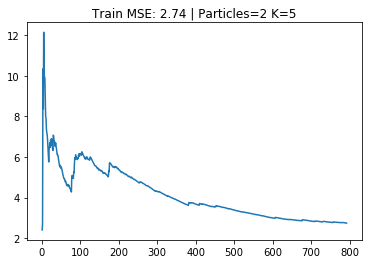

In [114]:
mses = moving_average(ses)
plt.plot(range(len(mses)), mses)
plt.title("Train MSE: {:.2f} | Particles=2 K=5".format(mses[-1]))
plt.savefig("MSE_graph.png")
plt.show()

In [187]:
# 1 user - get u vec 
# know how 
w = [.15, .25, .60 ]
l = [1, 2, 3]

x = np.random.random(l, w)

TypeError: random_sample() takes at most 1 positional argument (2 given)

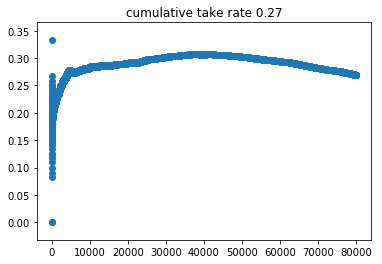

In [56]:
plt.scatter(range(len(ctr_hist)), ctr_hist)
plt.title("cumulative take rate {:.2f}".format(ctr_hist[-1]))
plt.show()